# Deep Learning – Assignment 1: Single-Word Audio Classification 

## Library

In [1]:
!nvidia-smi

Sun Apr 27 00:54:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8             13W /   75W |     193MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
from tqdm.notebook import tqdm
import random
from IPython.display import display, Audio

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Extract Audio

In [4]:
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.labels = []
        self.label_map = {}

        for idx, label in enumerate(sorted(os.listdir(root_dir))):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                self.label_map[idx] = label
                for file in os.listdir(label_path):
                    if file.endswith(".wav"):
                        self.samples.append(os.path.join(label_path, file))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        label = self.labels[idx]
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        feature = np.mean(mfcc.T, axis=0)
        return torch.tensor(feature, dtype=torch.float32), label

In [5]:
train_dataset = AudioDataset("Data_People/Training") # type: ignore
test_dataset = AudioDataset("Data_People/Testing") # type: ignore

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Training


In [ ]:
class AudioFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            #nn.Dropout(0.4), #
            nn.Linear(64, 32),
            nn.ReLU(),
            #nn.Dropout(0.4), #
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [7]:

input_size = 13
num_classes = len(train_dataset.label_map)
model = AudioFNN(input_size, num_classes) # type: ignore

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [8]:
# from torchsummary import summary

# summary(model, input_size=(1, 28, 28))

In [9]:
# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset) # type: ignore

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset) # type: ignore

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, history = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs=30, device=device)

Training Progress:   3%|▎         | 1/30 [00:03<01:54,  3.94s/it]

Epoch 1/30: Train loss: 13.2479, Train accuracy: 0.1905, Val loss: 2.3923, Val accuracy: 0.1667, Time: 3.93s


Training Progress:   7%|▋         | 2/30 [00:04<00:57,  2.04s/it]

Epoch 2/30: Train loss: 7.3413, Train accuracy: 0.2381, Val loss: 6.5652, Val accuracy: 0.3333, Time: 0.71s


Training Progress:  10%|█         | 3/30 [00:05<00:35,  1.33s/it]

Epoch 3/30: Train loss: 9.3247, Train accuracy: 0.2857, Val loss: 6.2422, Val accuracy: 0.3333, Time: 0.48s


Training Progress:  13%|█▎        | 4/30 [00:05<00:26,  1.02s/it]

Epoch 4/30: Train loss: 6.4461, Train accuracy: 0.3333, Val loss: 2.6709, Val accuracy: 0.3333, Time: 0.53s


Training Progress:  17%|█▋        | 5/30 [00:06<00:20,  1.21it/s]

Epoch 5/30: Train loss: 4.3605, Train accuracy: 0.3333, Val loss: 1.5939, Val accuracy: 0.3333, Time: 0.48s


Training Progress:  20%|██        | 6/30 [00:06<00:17,  1.35it/s]

Epoch 6/30: Train loss: 4.1859, Train accuracy: 0.3333, Val loss: 2.1371, Val accuracy: 0.3333, Time: 0.57s


Training Progress:  23%|██▎       | 7/30 [00:07<00:14,  1.54it/s]

Epoch 7/30: Train loss: 3.5315, Train accuracy: 0.2857, Val loss: 1.8111, Val accuracy: 0.2500, Time: 0.46s


Training Progress:  27%|██▋       | 8/30 [00:07<00:13,  1.66it/s]

Epoch 8/30: Train loss: 2.4306, Train accuracy: 0.3810, Val loss: 1.5163, Val accuracy: 0.3333, Time: 0.49s


Training Progress:  30%|███       | 9/30 [00:08<00:11,  1.77it/s]

Epoch 9/30: Train loss: 2.5297, Train accuracy: 0.2381, Val loss: 1.1624, Val accuracy: 0.3333, Time: 0.48s


Training Progress:  33%|███▎      | 10/30 [00:08<00:11,  1.75it/s]

Epoch 10/30: Train loss: 2.1694, Train accuracy: 0.2857, Val loss: 1.0673, Val accuracy: 0.5000, Time: 0.58s


Training Progress:  37%|███▋      | 11/30 [00:09<00:10,  1.83it/s]

Epoch 11/30: Train loss: 2.1637, Train accuracy: 0.2381, Val loss: 1.0582, Val accuracy: 0.4167, Time: 0.49s


Training Progress:  40%|████      | 12/30 [00:09<00:10,  1.78it/s]

Epoch 12/30: Train loss: 1.7246, Train accuracy: 0.4524, Val loss: 1.0654, Val accuracy: 0.3333, Time: 0.59s


Training Progress:  43%|████▎     | 13/30 [00:10<00:09,  1.88it/s]

Epoch 13/30: Train loss: 1.4552, Train accuracy: 0.3810, Val loss: 1.0713, Val accuracy: 0.3333, Time: 0.46s


Training Progress:  47%|████▋     | 14/30 [00:10<00:08,  1.87it/s]

Epoch 14/30: Train loss: 1.5188, Train accuracy: 0.3095, Val loss: 1.0799, Val accuracy: 0.3333, Time: 0.54s


Training Progress:  50%|█████     | 15/30 [00:11<00:07,  1.95it/s]

Epoch 15/30: Train loss: 1.3513, Train accuracy: 0.3095, Val loss: 1.0864, Val accuracy: 0.3333, Time: 0.46s


Training Progress:  53%|█████▎    | 16/30 [00:11<00:07,  1.95it/s]

Epoch 16/30: Train loss: 1.3442, Train accuracy: 0.3810, Val loss: 1.0876, Val accuracy: 0.3333, Time: 0.50s


Training Progress:  57%|█████▋    | 17/30 [00:12<00:06,  1.99it/s]

Epoch 17/30: Train loss: 1.2019, Train accuracy: 0.4048, Val loss: 1.0858, Val accuracy: 0.3333, Time: 0.48s


Training Progress:  60%|██████    | 18/30 [00:12<00:06,  1.99it/s]

Epoch 18/30: Train loss: 1.1420, Train accuracy: 0.3095, Val loss: 1.0874, Val accuracy: 0.3333, Time: 0.49s


Training Progress:  63%|██████▎   | 19/30 [00:13<00:05,  2.03it/s]

Epoch 19/30: Train loss: 1.1731, Train accuracy: 0.4048, Val loss: 1.0871, Val accuracy: 0.3333, Time: 0.46s


Training Progress:  67%|██████▋   | 20/30 [00:13<00:04,  2.02it/s]

Epoch 20/30: Train loss: 1.0825, Train accuracy: 0.5000, Val loss: 1.0883, Val accuracy: 0.3333, Time: 0.50s


Training Progress:  70%|███████   | 21/30 [00:14<00:04,  2.05it/s]

Epoch 21/30: Train loss: 1.2260, Train accuracy: 0.2857, Val loss: 1.0896, Val accuracy: 0.3333, Time: 0.46s


Training Progress:  73%|███████▎  | 22/30 [00:14<00:03,  2.02it/s]

Epoch 22/30: Train loss: 1.2121, Train accuracy: 0.3333, Val loss: 1.0896, Val accuracy: 0.3333, Time: 0.51s


Training Progress:  77%|███████▋  | 23/30 [00:15<00:03,  2.05it/s]

Epoch 23/30: Train loss: 1.1138, Train accuracy: 0.4524, Val loss: 1.0897, Val accuracy: 0.3333, Time: 0.47s


Training Progress:  80%|████████  | 24/30 [00:15<00:03,  2.00it/s]

Epoch 24/30: Train loss: 1.0733, Train accuracy: 0.4048, Val loss: 1.0890, Val accuracy: 0.3333, Time: 0.52s


Training Progress:  83%|████████▎ | 25/30 [00:16<00:02,  2.02it/s]

Epoch 25/30: Train loss: 1.1019, Train accuracy: 0.4048, Val loss: 1.0870, Val accuracy: 0.3333, Time: 0.47s


Training Progress:  87%|████████▋ | 26/30 [00:16<00:02,  1.98it/s]

Epoch 26/30: Train loss: 1.1384, Train accuracy: 0.3810, Val loss: 1.0848, Val accuracy: 0.3333, Time: 0.52s


Training Progress:  90%|█████████ | 27/30 [00:17<00:01,  2.01it/s]

Epoch 27/30: Train loss: 1.0237, Train accuracy: 0.4524, Val loss: 1.0826, Val accuracy: 0.3333, Time: 0.47s


Training Progress:  93%|█████████▎| 28/30 [00:17<00:01,  1.94it/s]

Epoch 28/30: Train loss: 1.1229, Train accuracy: 0.3571, Val loss: 1.0810, Val accuracy: 0.3333, Time: 0.55s


Training Progress:  97%|█████████▋| 29/30 [00:18<00:00,  2.00it/s]

Epoch 29/30: Train loss: 1.0761, Train accuracy: 0.2857, Val loss: 1.0801, Val accuracy: 0.3333, Time: 0.46s


Training Progress: 100%|██████████| 30/30 [00:18<00:00,  1.59it/s]

Epoch 30/30: Train loss: 1.0109, Train accuracy: 0.5238, Val loss: 1.0796, Val accuracy: 0.3333, Time: 0.54s


## Result


In [11]:
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

print(accuracy_score(y_true, y_pred))

0.3333333333333333


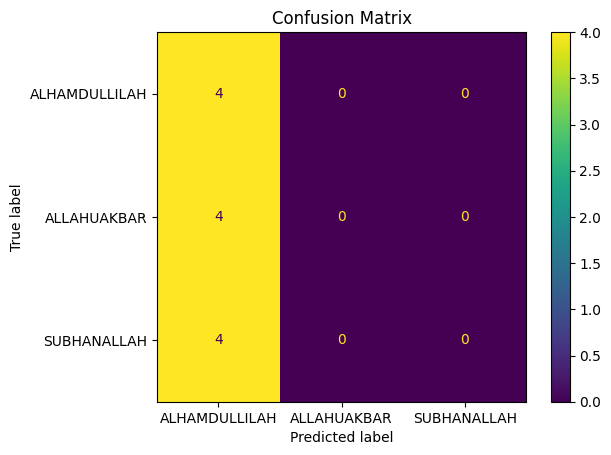

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[train_dataset.label_map[i] for i in range(num_classes)]).plot()
plt.title("Confusion Matrix")
plt.show()

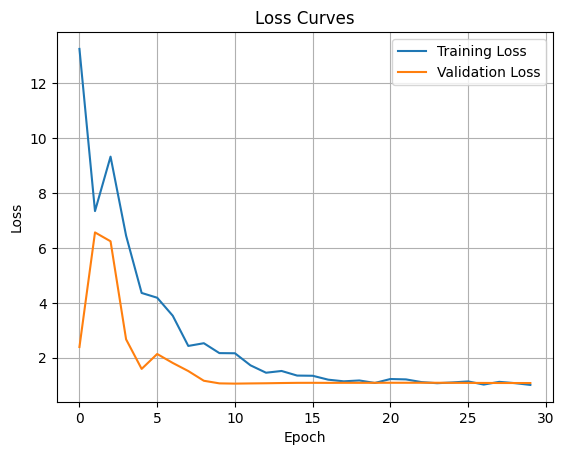

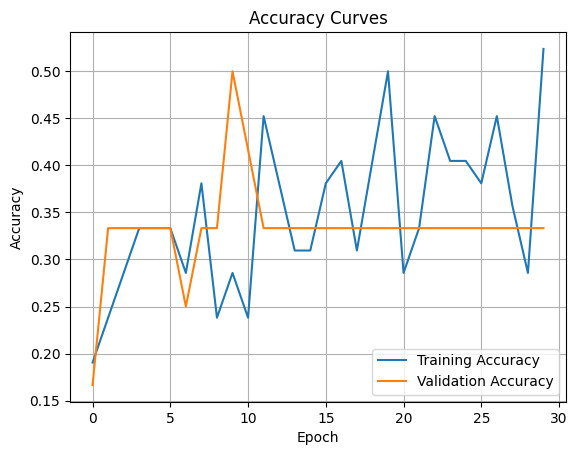

In [13]:
plt.figure()
plt.plot(history['train_loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history['train_accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()